In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mutual_info_score
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import set_config
import numpy as np

In [6]:
set_config(transform_output="pandas")

In [7]:
df = pd.read_csv("./data/customer_churn_processed_data.csv")

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   creditscore      10000 non-null  int64  
 1   country          10000 non-null  object 
 2   gender           10000 non-null  object 
 3   age              10000 non-null  int64  
 4   tenure           10000 non-null  int64  
 5   balance          10000 non-null  float64
 6   numofproducts    10000 non-null  int64  
 7   hascrcard        10000 non-null  int64  
 8   isactivemember   10000 non-null  int64  
 9   estimatedsalary  10000 non-null  float64
 10  exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


In [9]:
numeric_cols = df.select_dtypes("number").columns.drop(["exited", "hascrcard", "isactivemember"]).to_list()
categorical_cols = df.select_dtypes("object").columns.tolist() + ["hascrcard", "isactivemember"]

numeric_cols, categorical_cols

(['creditscore',
  'age',
  'tenure',
  'balance',
  'numofproducts',
  'estimatedsalary'],
 ['country', 'gender', 'hascrcard', 'isactivemember'])

In [11]:
# Transform categorical cols

X = df.drop("exited", axis=1)
scaler = StandardScaler()
X_scaled = pd.concat(
    [
        scaler.fit_transform(X[numeric_cols]),
        X[categorical_cols]
    ],
    axis=1
)
X_scaled["gender"] = X["gender"].map({"female": 0, "male": 1})
X_scaled = pd.concat(
    [
        X_scaled.drop("country", axis=1),
        pd.get_dummies(df["country"]).astype(int)
    ],
    axis=1
)

In [13]:
X_scaled.head()

,creditscore,age,tenure,balance,numofproducts,estimatedsalary,gender,hascrcard,isactivemember,france,germany,spain
0,-0.326221,0.293517,-1.041760,-1.225848,-0.911583,0.021886,0,1,1,1,0,0
1,-0.440036,0.198164,-1.387538,0.117350,-0.911583,0.216534,0,0,1,0,0,1
2,-1.536794,0.293517,1.032908,1.333053,2.527057,0.240687,0,1,0,1,0,0
3,0.501521,0.007457,-1.387538,-1.225848,0.807737,-0.108918,0,0,0,1,0,0
4,2.063884,0.388871,-1.041760,0.785728,-0.911583,-0.365276,0,1,1,0,0,1


### Find optimal K

In [14]:
inertias = []
sl_scores = []
n_clusters = range(2, 20)

for n_cluster in n_clusters:
    _kmeans = KMeans(n_cluster, random_state=42)
    _kmeans.fit(X_scaled)
    _inertia = _kmeans.inertia_
    _sl_score = silhouette_score(X_scaled, _kmeans.labels_)

    inertias.append(_inertia)
    sl_scores.append(_sl_score)

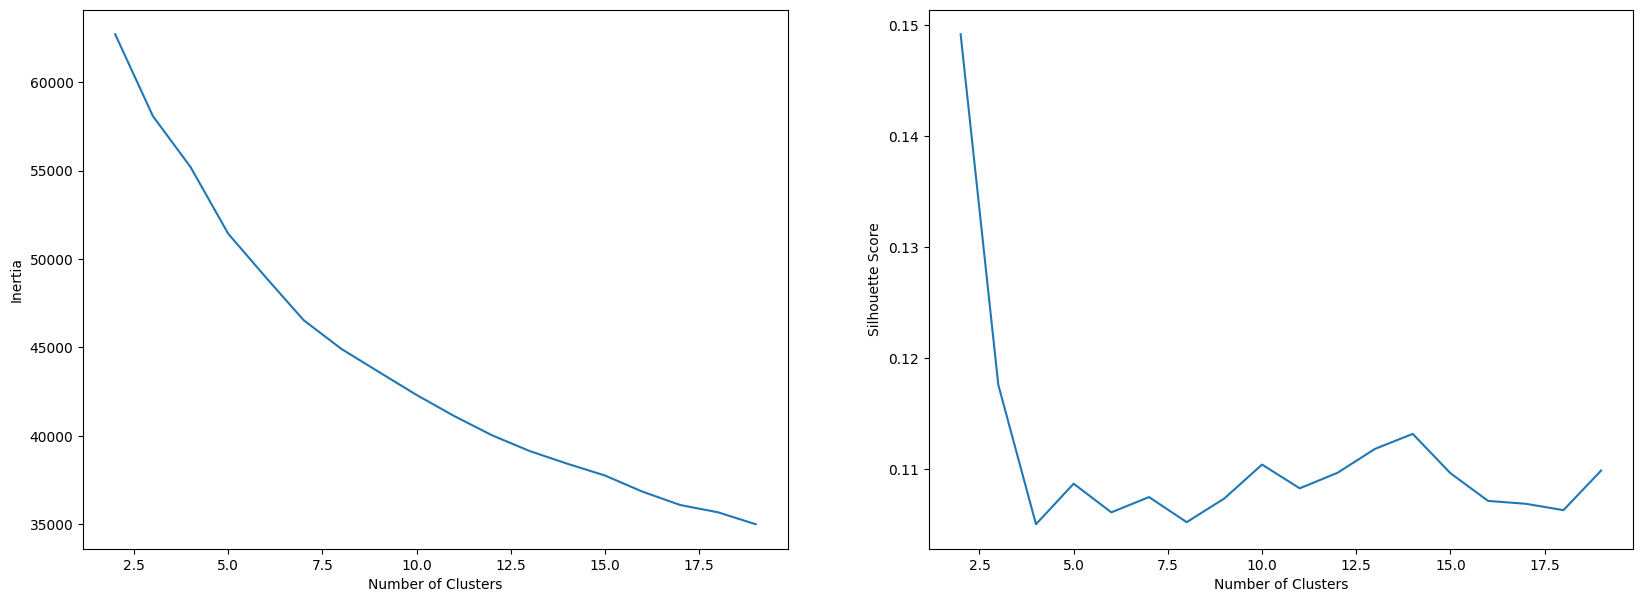

In [35]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))

ax1.plot(n_clusters, inertias)
ax1.set_xlabel("Number of Clusters")
ax1.set_ylabel("Inertia")

ax2.plot(n_clusters, sl_scores)
ax2.set_xlabel("Number of Clusters")
ax2.set_ylabel("Silhouette Score");

In [38]:
pd.DataFrame(
    {
        "n_cluster": n_clusters,
        "inertia": inertias,
        "sl_score": sl_scores
    }
).sort_values("sl_score", ascending=False).head(5)

,n_cluster,inertia,sl_score
0,2,62717.781972,0.149179
1,3,58090.834312,0.117572
12,14,38424.772724,0.113149
11,13,39141.239082,0.111802
8,10,42313.382298,0.110386


In [39]:
kmeans = KMeans(14, random_state=42)
kmeans.fit(X_scaled)

,n_clusters,14
,init,'k-means++'
,n_init,'auto'
,max_iter,300
,tol,0.0001
,verbose,0
,random_state,42
,copy_x,True
,algorithm,'lloyd'


In [48]:
df_clustered = df.assign(cluster_label=kmeans.labels_)
df_clustered.head()

,creditscore,country,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited,cluster_label
0,619,france,female,42,2,0.00,1,1,1,101348.88,1,5
1,608,spain,female,41,1,83807.86,1,0,1,112542.58,0,4
2,502,france,female,42,8,159660.80,3,1,0,113931.57,1,10
3,699,france,female,39,1,0.00,2,0,0,93826.63,0,8
4,850,spain,female,43,2,125510.82,1,1,1,79084.10,0,1


### Analyze cluster result

In [44]:
df_clustered["cluster_label"].value_counts()

cluster_label
9     933
4     923
1     918
11    908
13    750
3     716
5     699
8     681
6     653
10    652
2     652
7     591
0     567
12    357
Name: count, dtype: int64

cluster_label
0     692.483245
1     700.868192
2     554.466258
3     734.920391
4     571.900325
5     622.107296
6     666.954058
7     652.490694
8     671.170338
9     719.115756
10    608.134969
11    604.381057
12    669.347339
13    647.249333
Name: creditscore, dtype: float64


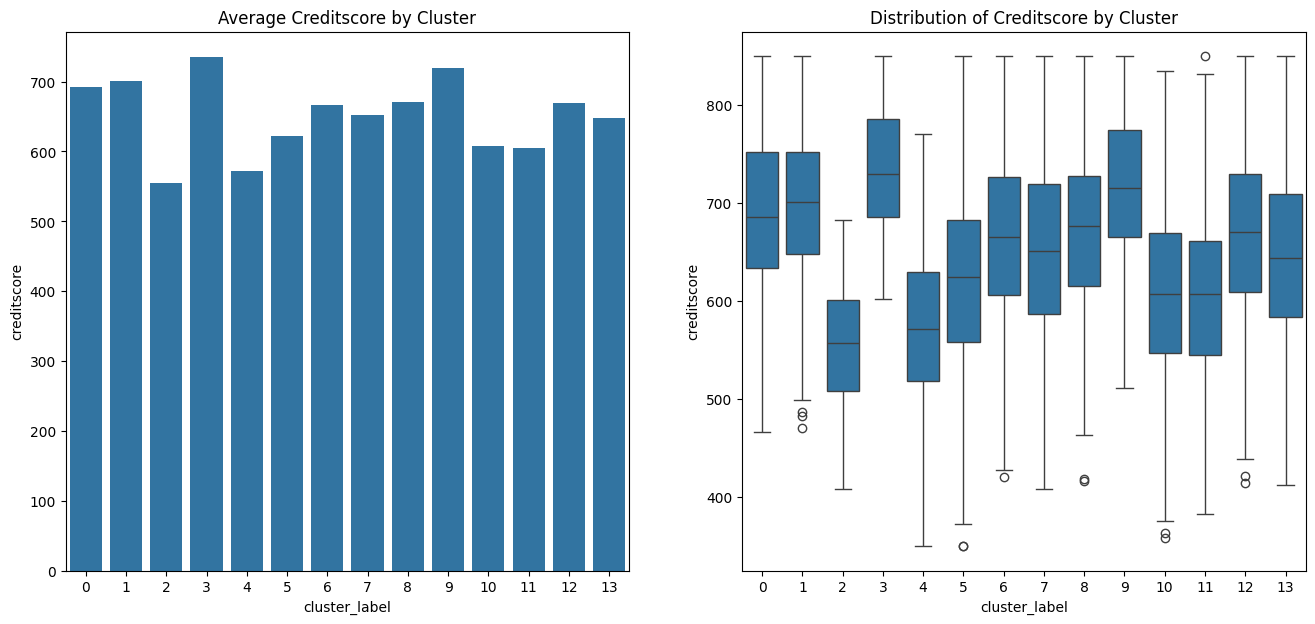

cluster_label
0     37.077601
1     36.055556
2     36.072086
3     34.909218
4     36.864572
5     39.696710
6     36.686064
7     60.568528
8     35.418502
9     36.368703
10    38.335890
11    36.838106
12    62.829132
13    34.840000
Name: age, dtype: float64


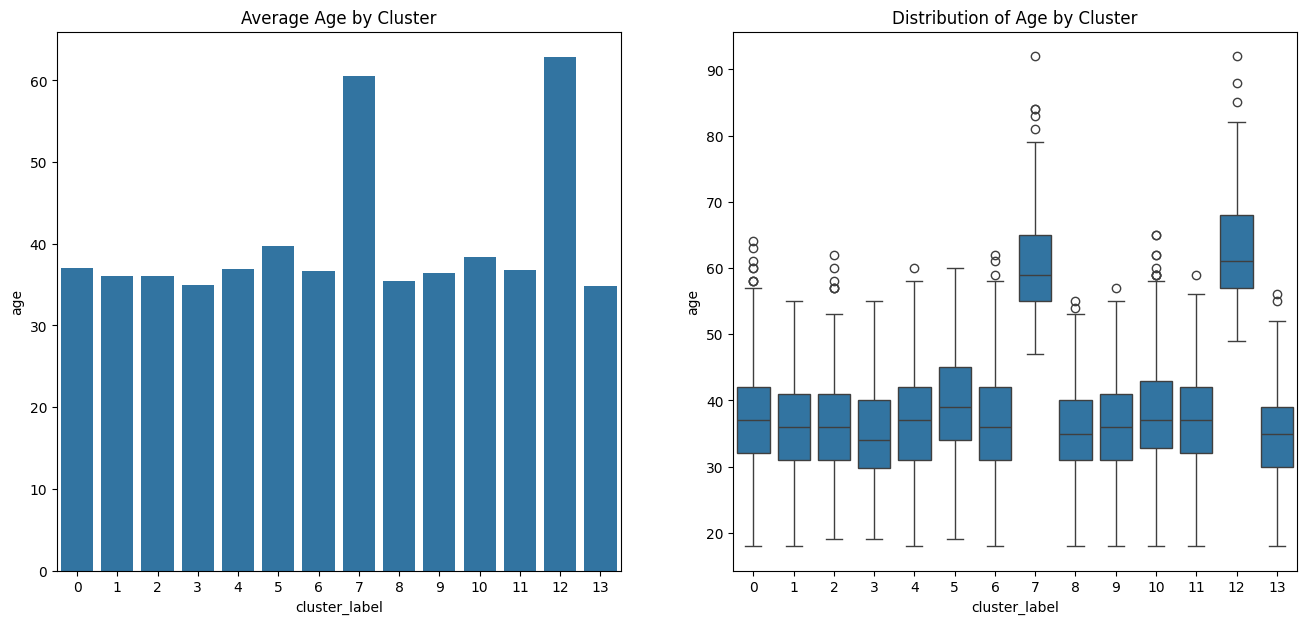

cluster_label
0     3.238095
1     2.751634
2     4.363497
3     6.025140
4     2.647887
5     4.806867
6     3.503828
7     4.966159
8     2.205580
9     6.811361
10    7.929448
11    7.659692
12    4.731092
13    7.878667
Name: tenure, dtype: float64


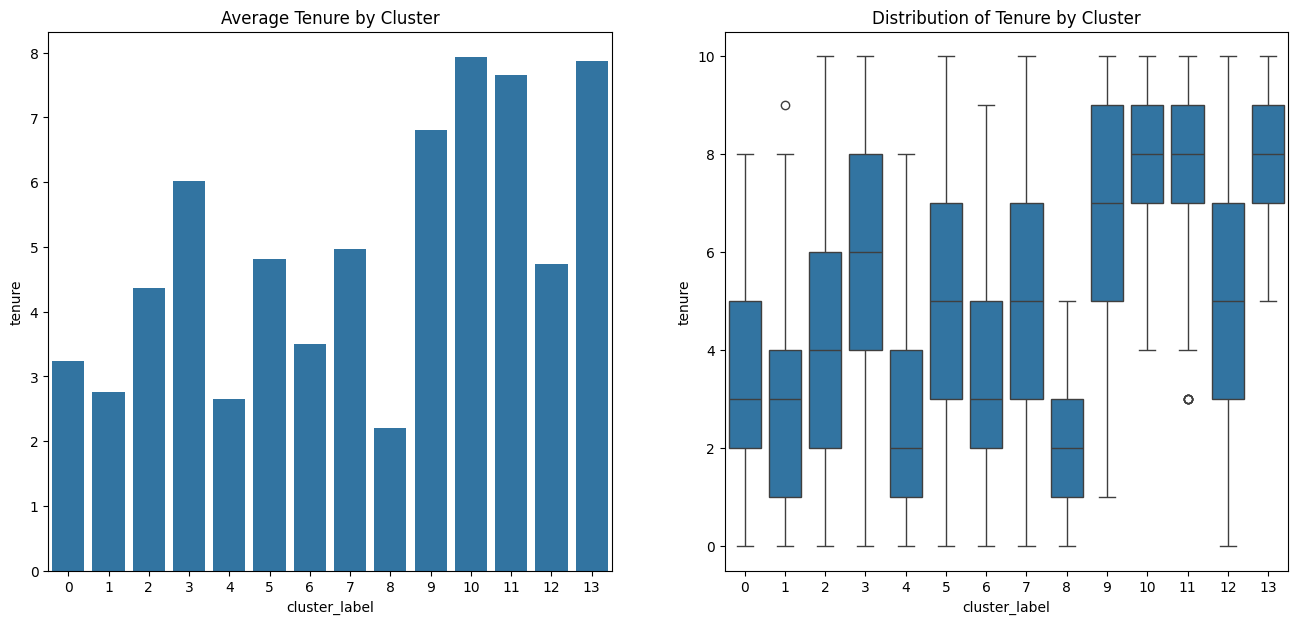

cluster_label
0     121514.136878
1     119115.327429
2       4491.225276
3       3733.582598
4     121889.913294
5       3311.568856
6     124083.725115
7     121970.526227
8       2125.814097
9     120346.593591
10    123824.774724
11    122500.737037
12      9817.835126
13      5173.482480
Name: balance, dtype: float64


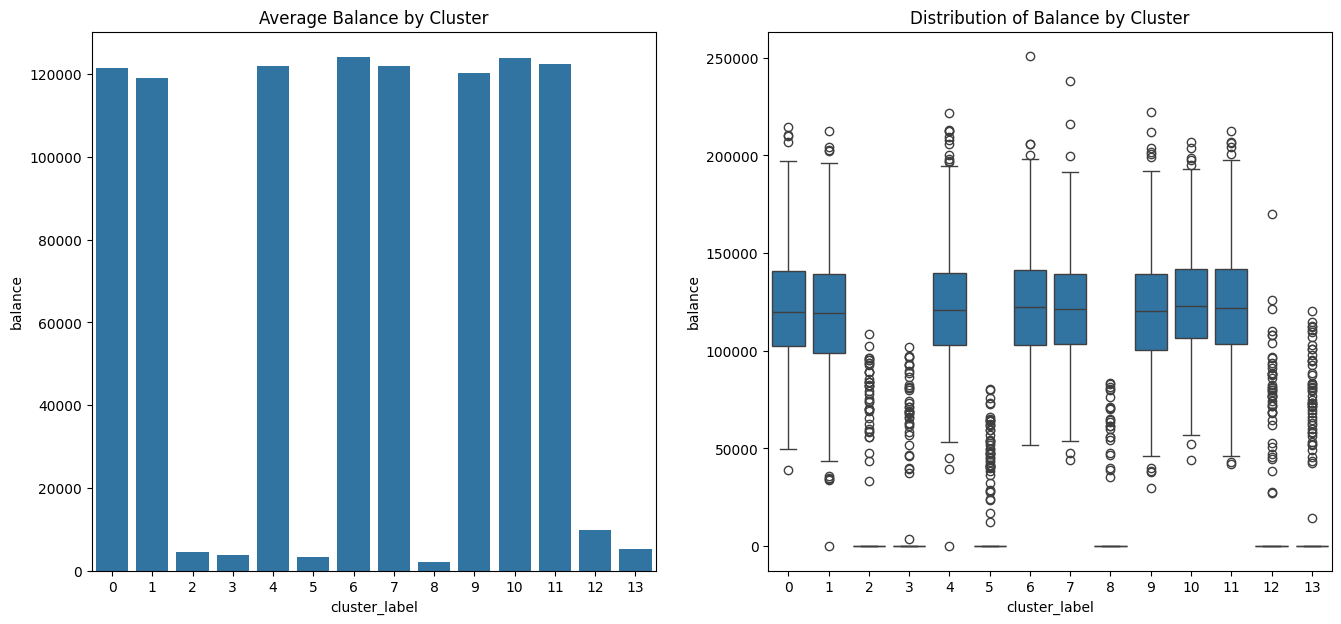

cluster_label
0     2.130511
1     1.000000
2     2.061350
3     1.990223
4     1.037920
5     1.000000
6     2.110260
7     1.147208
8     1.964758
9     1.019293
10    2.147239
11    1.002203
12    1.831933
13    1.921333
Name: numofproducts, dtype: float64


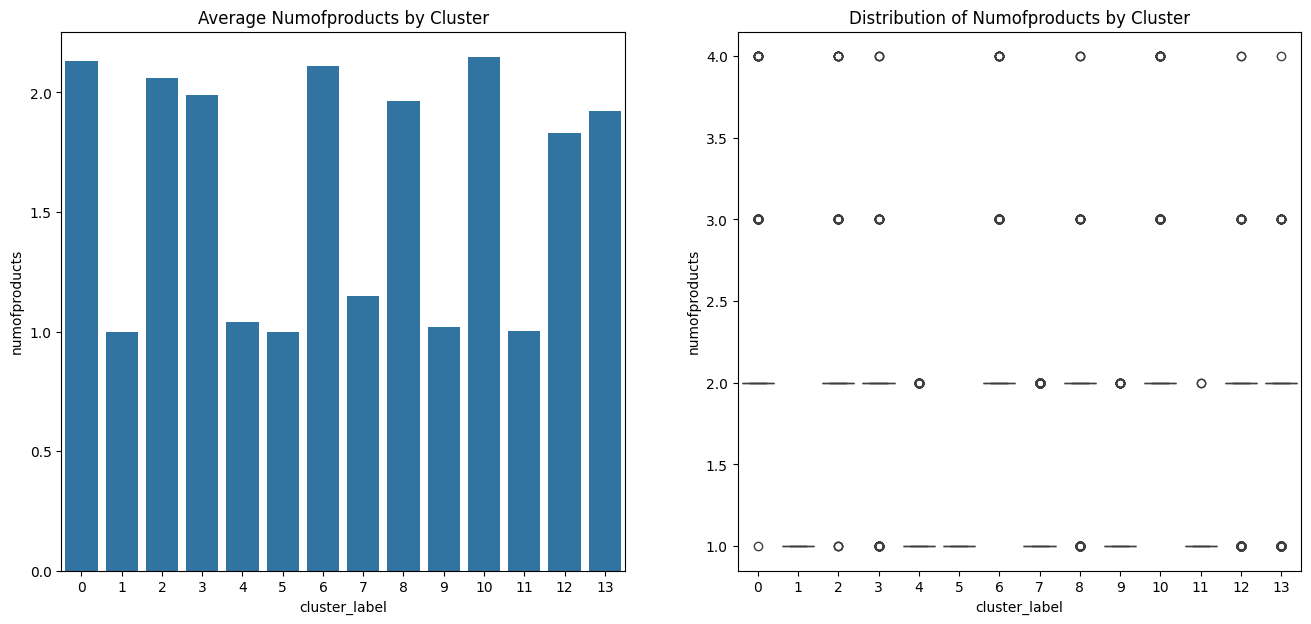

cluster_label
0     152015.565467
1      52639.599706
2     142062.187086
3     150740.452095
4     140432.420553
5     111132.645207
6      46725.710230
7      95687.170305
8      52411.497812
9     148710.337031
10    114940.362500
11     60827.426960
12     87289.722633
13     47592.047880
Name: estimatedsalary, dtype: float64


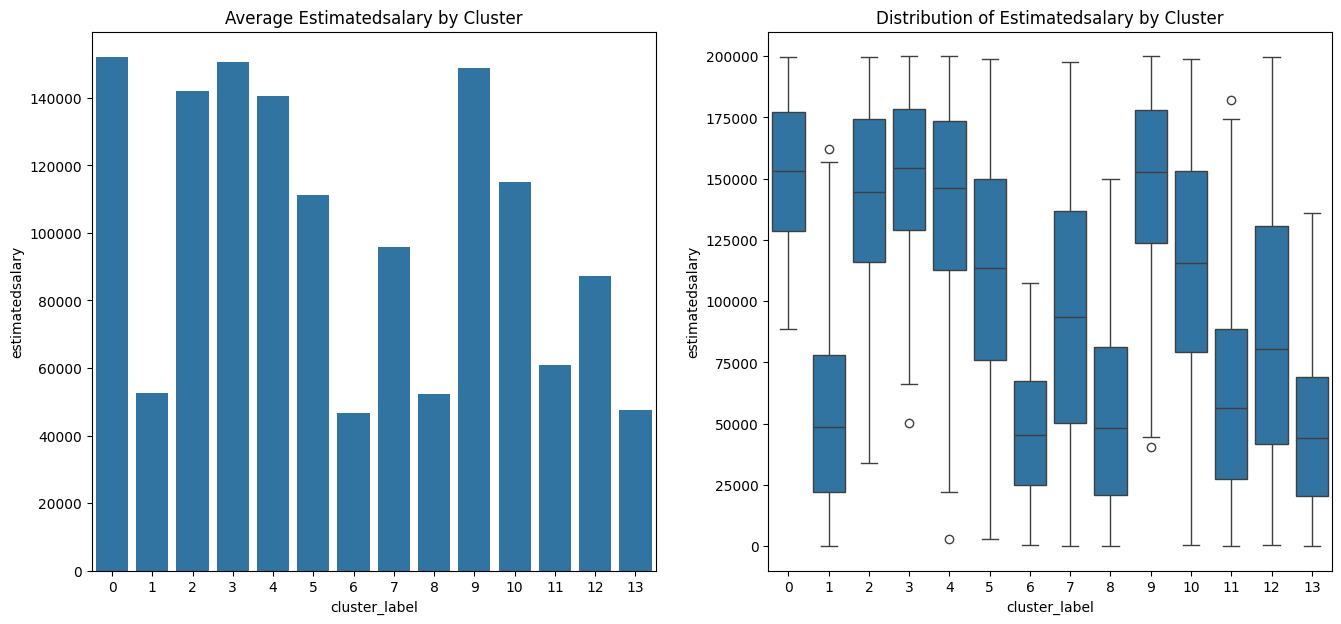

In [45]:
for col in numeric_cols:
    group_average = df_clustered.groupby("cluster_label")[col].mean()
    print(group_average)

    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

    sns.barplot(group_average, ax=ax1)
    sns.boxplot(df_clustered, x="cluster_label", y=col, ax=ax2)
    ax1.set_title(f"Average {col.title()} by Cluster")
    ax2.set_title(f"Distribution of {col.title()} by Cluster")
    plt.show()

#### Analyze categories

cluster_label
0     0.194004
1     0.208061
2     0.078221
3     0.069832
4     0.237270
5     0.384835
6     0.194487
7     0.441624
8     0.076358
9     0.227224
10    0.226994
11    0.225771
12    0.260504
13    0.065333
Name: exited, dtype: float64


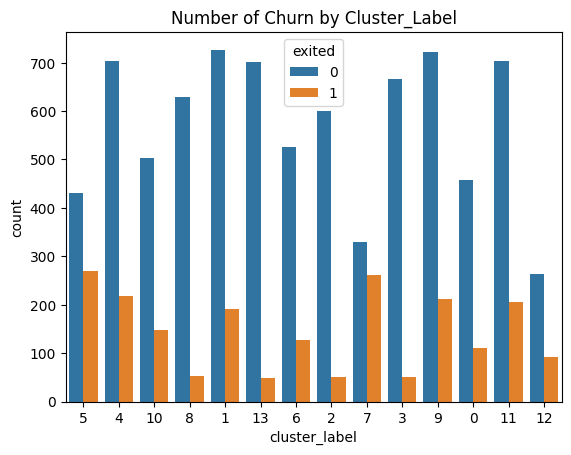

In [49]:
# for col in categorical_cols:
group_churn_rate = df_clustered.groupby("cluster_label")["exited"].mean()
print(group_churn_rate)
sns.countplot(x=df_clustered["cluster_label"].astype(str), hue=df["exited"])
plt.title(f"Number of Churn by {"cluster_label".title()}")
plt.show()

In [50]:
mutual_info_score(df["exited"], df_clustered["cluster_label"])

0.03437106015490536

In [51]:
pd.crosstab(df_clustered["country"], df_clustered["cluster_label"], normalize="columns")

cluster_label,0,1,2,3,4,5,6,7,8,9,10,11,12,13
country,,,,,,,,,,,,,,
france,0.285714,0.492375,0.676380,0.660615,0.449621,0.680973,0.283308,0.358714,0.659325,0.455520,0.286810,0.457048,0.649860,0.653333
germany,0.557319,0.314815,0.007669,0.005587,0.328277,0.007153,0.545176,0.421320,0.005874,0.324759,0.578221,0.299559,0.033613,0.018667
spain,0.156966,0.192810,0.315951,0.333799,0.222102,0.311874,0.171516,0.219966,0.334802,0.219721,0.134969,0.243392,0.316527,0.328000


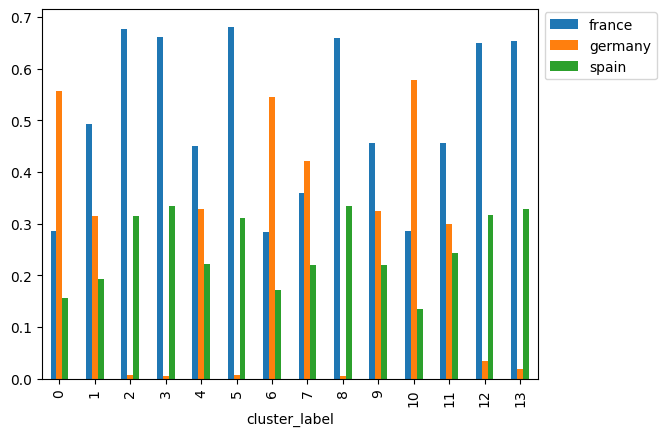

In [ ]:
pd.crosstab(df_clustered["country"], df_clustered["cluster_label"], normalize="columns").T.plot(kind="bar")
plt.legend(bbox_to_anchor=[1, 1.01]);

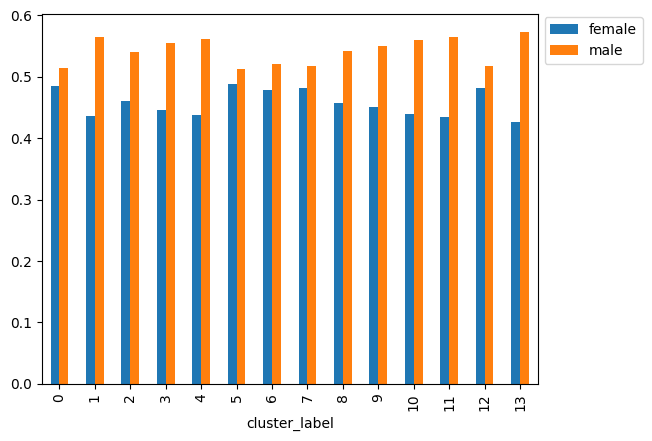

In [55]:
pd.crosstab(df_clustered["gender"], df_clustered["cluster_label"], normalize="columns").T.plot(kind="bar")
plt.legend(bbox_to_anchor=[1, 1.01]);

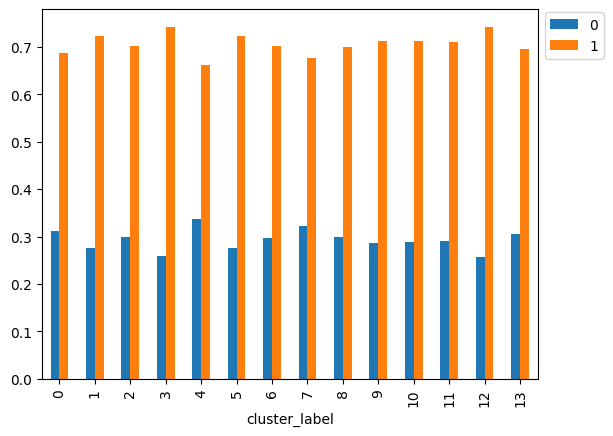

In [56]:
pd.crosstab(df_clustered["hascrcard"], df_clustered["cluster_label"], normalize="columns").T.plot(kind="bar")
plt.legend(bbox_to_anchor=[1, 1.01]);

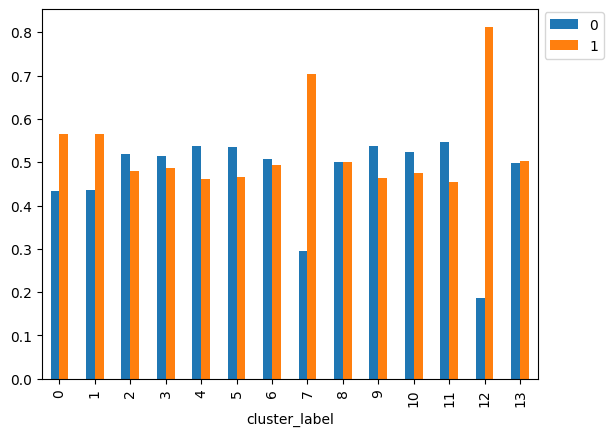

In [57]:
pd.crosstab(df_clustered["isactivemember"], df_clustered["cluster_label"], normalize="columns").T.plot(kind="bar")
plt.legend(bbox_to_anchor=[1, 1.01]);

#### Visualize

In [64]:
pca = PCA(3)
pca_df = pca.fit_transform(
    X_scaled[numeric_cols]
)
pca_df.head()

,pca0,pca1,pca2
0,0.108803,-0.868872,-0.337048
1,-0.838216,-0.766997,-0.402084
2,0.840694,0.464010,-1.593447
3,1.340801,-0.990392,0.548428
4,-1.275429,-0.644994,2.103874


In [65]:
pca.explained_variance_ratio_

array([0.21851529, 0.16891898, 0.16685929])

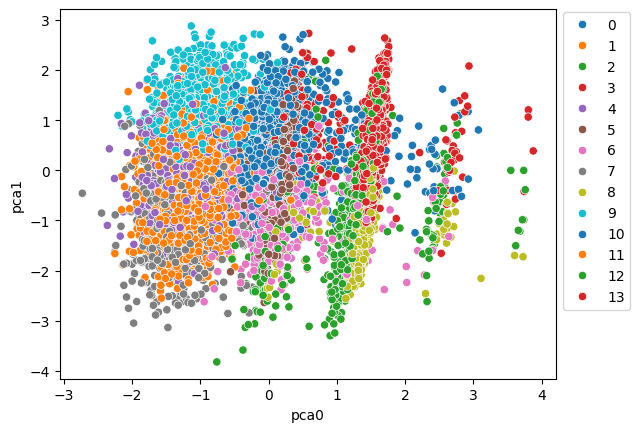

In [63]:
sns.scatterplot(pca_df, x="pca0", y="pca1", hue=df_clustered["cluster_label"], palette=sns.color_palette(n_colors=14))
plt.legend(bbox_to_anchor=[1, 1.01]);

In [67]:
import plotly.express as px

In [70]:
px.scatter_3d(pca_df, x="pca0", y="pca1", z="pca2", color=df_clustered["cluster_label"].astype(str))